### 1.Import packages and datasets.

In [ ]:
#Import FairML package from github
!pip -q install https://github.com/adebayoj/fairml/archive/master.zip
from fairml import audit_model
from fairml import plot_dependencies
!pip -q install pyreadstat

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, zmap
from sklearn.model_selection import train_test_split
import seaborn as sns
from IPython.display import Markdown, display

# Import dataset
!wget -q https://www.dropbox.com/s/7rd15y2jdam5wls/carsales.sav
!wget -q https://www.dropbox.com/s/0ctjebkulbqv23z/Professional_Sales_Applicants.sav

df  = pd.read_spss('carsales.sav')
test = pd.read_spss("Professional_Sales_Applicants.sav")

ERROR: Operation cancelled by user


### 2.Data preprocessing

In [ ]:
df=df.dropna()
test=test.dropna()

df["Gender"].value_counts()

Male                 246
Female                60
Prefer not to say      7
Name: Gender, dtype: int64

#### Create protected attributes.

In [ ]:
# create dummy variables as protected attributes.
race=pd.get_dummies(df['Race'],drop_first=True)
Ageband=pd.get_dummies(df['AgeBand'],drop_first=True)
Gender=pd.get_dummies(df['Gender'],drop_first=False)

protected=pd.concat([race,Ageband,Gender], axis=1)

In [ ]:
# Create train dataset

X_train = df.iloc[:,6:28]
X_train=pd.concat([protected,X_train],axis=1)

### 3. Apply linear regression model

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression() 
lm.fit(X_train,df.OverallRating )
display(Markdown("### Coefficients: "))
print(lm.coef_)
display(Markdown("### Intercept: "))
print( lm.intercept_)

### Coefficients: 

[-0.32338706 -0.71523325 -0.54595509  0.23484685 -0.71980066 -0.80396386
 -0.45112853 -0.57820937  0.80319649  0.61758909  0.96813076  0.87591107
  0.37916555  0.19844382 -0.19574404 -0.16688529  0.36262934 -0.26670467
 -0.1106499  -0.21401475  0.55106546 -0.4220611  -0.88663508 -0.83786609
 -0.40456475  0.33552625  0.10320368 -0.44253612  0.30304852  0.3618732
  0.2168877   0.99636938  0.36611458  0.0640043   0.36468534  1.22491894
 -0.04277499]


### Intercept: 

2.8331436442976052


### 4. Checking bias and plot importancies via FairML

In [ ]:
importancies, _ = audit_model(lm.predict, X_train)
display(Markdown("### Feature importancies: "))
print(importancies)

### Feature importancies: 

Feature: Asian (not Hispanic or Latino),	 Importance: -0.0367211729012398
Feature: Black or African American (not Hispanic or Latino),	 Importance: -0.04305876910199568
Feature: Hispanic or Latino,	 Importance: -0.047035366937145405
Feature: Native Hawaiian or Other Pacific Islander (not Hispanic or Latino),	 Importance: 0.004913827858629171
Feature: Other,	 Importance: -0.010362979136053179
Feature: Prefer Not To Say,	 Importance: -0.00041356149149038475
Feature: Two or More Races (not Hispanic or Latino),	 Importance: -0.00942556329163912
Feature: White (not Hispanic or Latino),	 Importance: -0.11436450762892701
Feature: 20-29,	 Importance: 0.09601208363569697
Feature: 30-39,	 Importance: 0.036505136477331966
Feature: 40-49,	 Importance: 0.09216863700896939
Feature: 50-59,	 Importance: 0.0734031691296604
Feature: 60 or over,	 Importance: 0.004531870049912482
Feature: Female,	 Importance: -0.07102862789365265
Feature: Male,	 Importance: -0.19164146880804594
Feature: Prefer not to say,

In [ ]:
import matplotlib

# temporary work around down to virtualenv
# matplotlib issue.
matplotlib.use('Agg')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


def plot_dependencies(dictionary_values,
                      pos_color="#3DE8F7",
                      negative_color="#ff4d4d",
                      reverse_values=False,
                      title="",
                      fig_size=(20, 20)):

    # add check to make sure that dependence features are not zeros
    if np.sum(np.array(dictionary_values.values())) == 0.0:
        print("Feature dependence for all attributes equal zero."
              " There is nothing to plot here. ")
        return None

    column_names = list(dictionary_values.keys())
    coefficient_values = list(dictionary_values.values())

    # get maximum
    maximum_value = np.absolute(np.array(coefficient_values)).max()
    coefficient_values = ((np.array(coefficient_values) / maximum_value) * 100
                          )

    index_sorted = np.argsort(np.array(coefficient_values))
    sorted_column_names = list(np.array(column_names)[index_sorted])
    sorted_column_values = list(np.array(coefficient_values)[index_sorted])

    pos = np.arange(len(sorted_column_values)) + 0.7

    # rearrange this at some other point.
    def assign_colors_to_bars(array_values,
                              pos_influence=pos_color,
                              negative_influence=negative_color,
                              reverse=reverse_values):

        # if you want the colors to be reversed for positive
        # and negative influences.
        if reverse:
            pos_influence, negative_influence = (negative_influence,
                                                 pos_influence)

        # could rewrite this as a lambda function
        # but I understand this better
        def map_x(x):
            if x > 0:
                return pos_influence
            else:
                return negative_influence
        bar_colors = list(map(map_x, array_values))
        return bar_colors

    fig = plt.figure(figsize=fig_size)

    bar_colors = assign_colors_to_bars(coefficient_values, reverse=True)
    bar_colors = list(np.array(bar_colors)[index_sorted])

    plt.barh(pos, sorted_column_values, align='center', color=bar_colors)
    plt.yticks(pos, sorted_column_names)
    plt.xlim(-105, 105)

    if title:
        plt.title("{}".format(title))

    return fig


#### Generate importancies plot


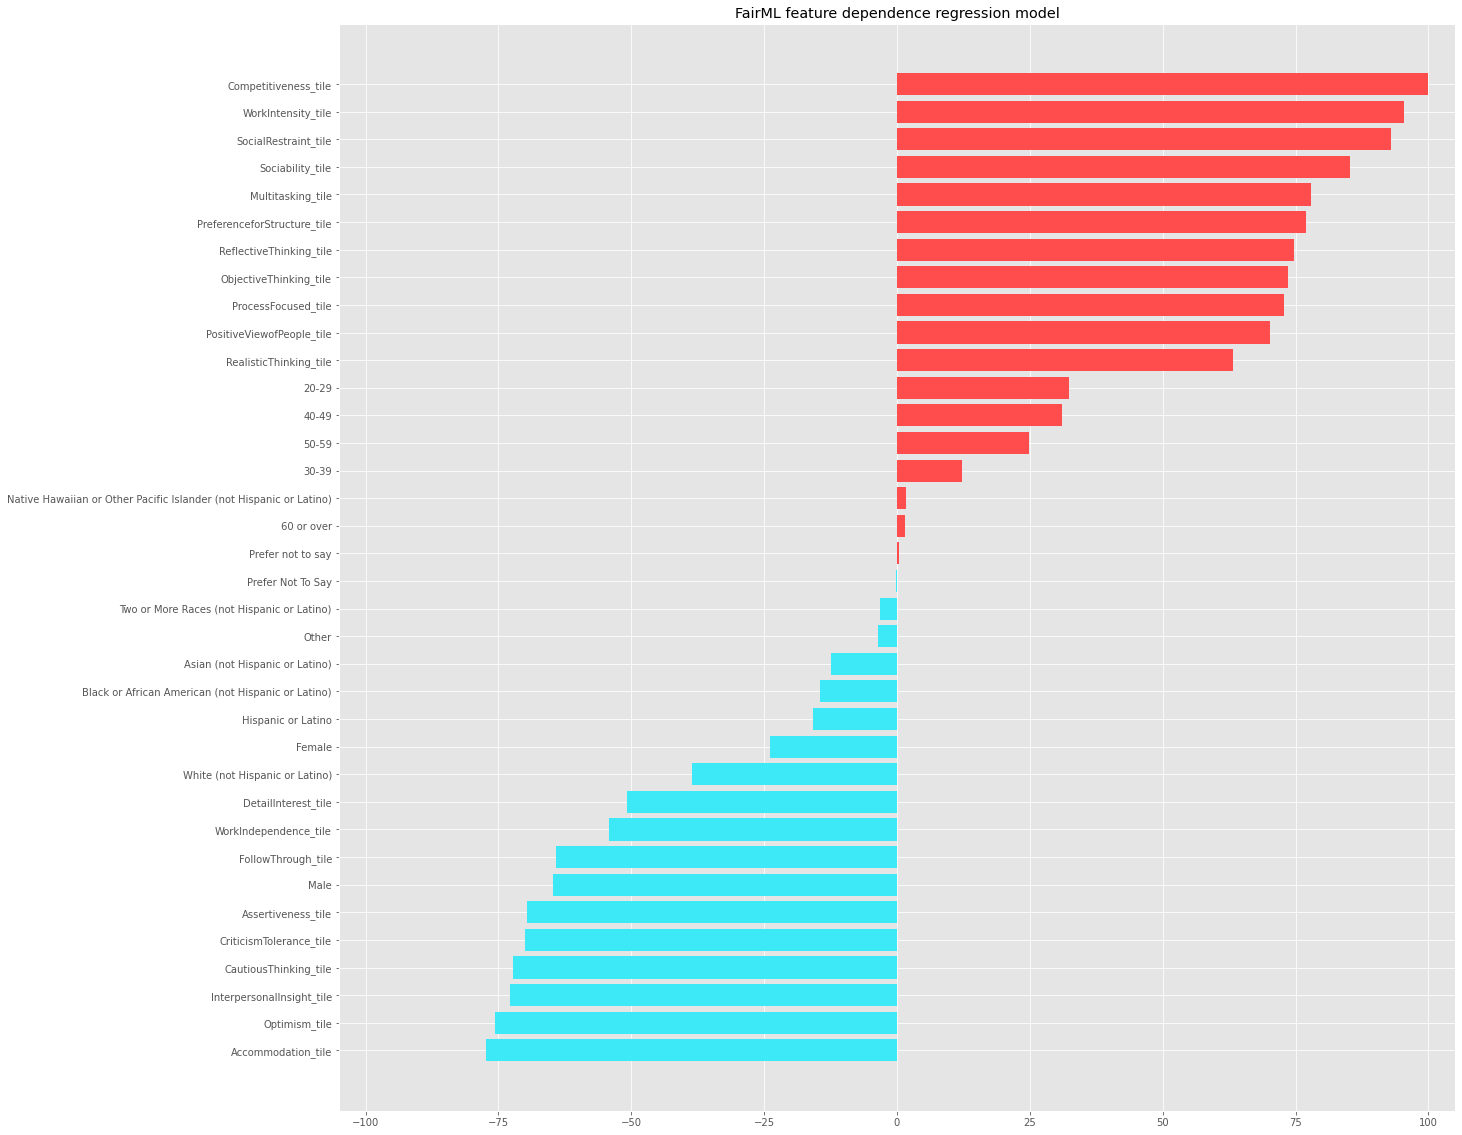

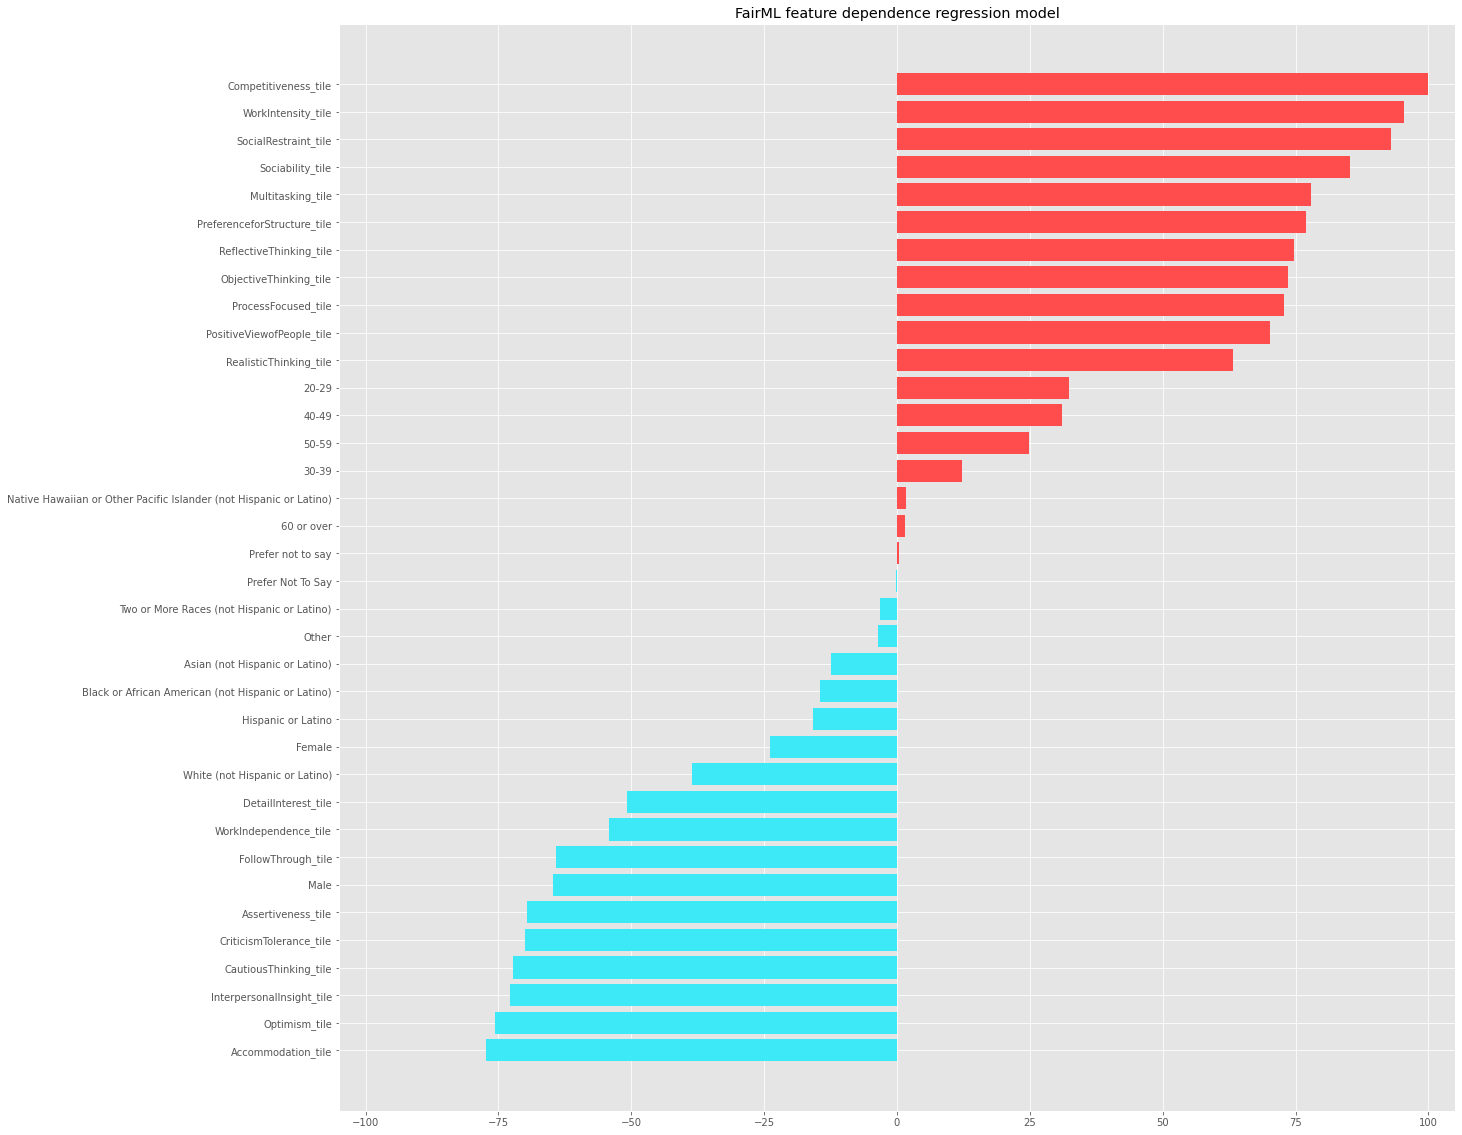

In [ ]:
plot_dependencies(importancies.median(),
    reverse_values=False,
    title="FairML feature dependence regression model"
)

#file_name = "fairml_propublica_linear_direct.png"
#plt.savefig(file_name, transparent=False, bbox_inches='loose',dpi=250)